### Here we performed the under sampling and later fitted the data set on to the classification models like Random forest classifier and Support vector machine .

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')
data=pd.read_csv('final.csv')
data2=pd.read_csv('final.csv')
data2.head()
data=data.drop(['Unnamed: 0'],axis=1)
data.head()

,Passwords,length,Has_Upper,Has_Numeric,Has_SpecialChar,UpperCase_Count,LowerCase_Count,Numeric_Count,SpecialChar_Count,Alphabet_Count,Password_Source,Has_Word,Has_Name,Has_Place,Score,Password_Strength
0,@fl!pm0de@,10,0,1,1,0,6,1,3,6,Yahoo,0,0,0,5,Strong
1,pass,4,0,0,0,0,4,0,0,4,Yahoo,0,0,1,1,Weak
2,steveol,7,0,0,0,0,7,0,0,7,Yahoo,0,1,0,2,Weak
3,chotzi,6,0,0,0,0,6,0,0,6,Yahoo,0,1,0,1,Weak
4,lb2512,6,0,1,0,0,2,4,0,2,Yahoo,0,0,0,3,Medium


In [2]:
data.shape

(454482, 16)

In [3]:
data3=data2.groupby('Password_Source')['Passwords'].count().reset_index()
data3

,Password_Source,Passwords
0,Hotmail,9812
1,Netflix,1832
2,Yahoo,442838


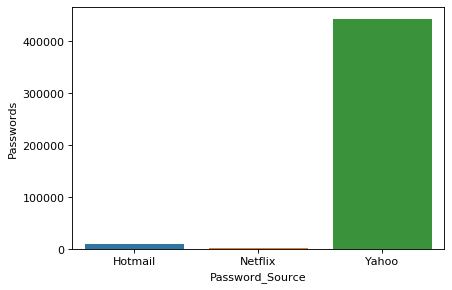

In [4]:
plt.figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')
sns.barplot(x='Password_Source', y='Passwords', data=data3, estimator=np.median)
plt.show()

In [5]:
from sklearn.preprocessing import LabelEncoder

number = LabelEncoder()
data['Passwords'] = number.fit_transform(data['Passwords'].astype('str'))


In [6]:

X=data.drop(['Password_Source','Password_Strength'],axis=1)

Y=data.Password_Source


### Randomly undersampling the data 

In [8]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(return_indices=True)
X, Y, id_rus = rus.fit_sample(X, Y)

print('Removed indexes:', id_rus)

Removed indexes: [452551 443181 450190 ... 359971  90198  31348]


In [9]:
X1=pd.DataFrame(data=X,columns=['Passwords','length','Has_Upper','Has_Numeric','Has_SpecialChar','UpperCase_Count','LowerCase_Count','Numeric_Count','SpecialChar_Count','Alphabet_Count','Has_Word','Has_Word','Has_Name','Has_Place']) 
Y1=pd.DataFrame(data=Y,columns=['Password_Source'])
X1['Password_Source']=Y1['Password_Source']

In [10]:
X4=X1.groupby('Password_Source')['Passwords'].count().reset_index()
X4

,Password_Source,Passwords
0,Hotmail,1832
1,Netflix,1832
2,Yahoo,1832


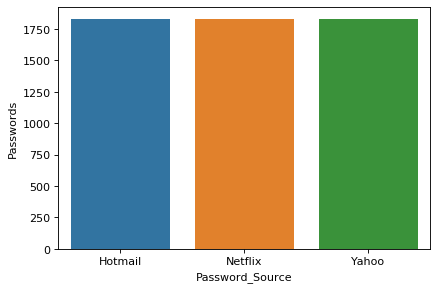

In [11]:
import seaborn as sns
plt.figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')
sns.barplot(x='Password_Source', y='Passwords', data=X4, estimator=np.median)
plt.show()

In [ ]:
results=pd.DataFrame(columns=['Classifier','Accuracy','Precision','Recall','F-score'])

### Random Forest Classifier

In [12]:
#Splitting the data set into training and testing 
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.3)

In [13]:
data.name='data'

In [14]:
data.columns

Index(['Passwords', 'length', 'Has_Upper', 'Has_Numeric', 'Has_SpecialChar',
       'UpperCase_Count', 'LowerCase_Count', 'Numeric_Count',
       'SpecialChar_Count', 'Alphabet_Count', 'Password_Source', 'Has_Word',
       'Has_Name', 'Has_Place', 'Score', 'Password_Strength'],
      dtype='object')

### Without Tuning

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
rf = RandomForestClassifier(max_depth=10)
rf1 = RandomForestClassifier(max_depth=30)
rf1.fit(xtrain, ytrain)
rf.fit(xtrain, ytrain)
met= precision_recall_fscore_support(ytest, rf.predict(xtest), average='macro')
print(met[0])

0.5440073989179163


###  Finding the best parameters using Randomised search CV

In [16]:
from sklearn.ensemble import RandomForestClassifier
rf_0 = RandomForestClassifier(random_state = 8)
print('Parameters currently in use:\n')
print(rf_0.get_params())

Parameters currently in use:

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 'warn', 'n_jobs': None, 'oob_score': False, 'random_state': 8, 'verbose': 0, 'warm_start': False}


In [17]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]

max_features = ['auto', 'sqrt','log2']

max_depth = [int(x) for x in np.linspace(20, 100, num = 5)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [20, 40, 60, 80, 100, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [18]:
# creating the base model to tune
rfc = RandomForestClassifier(random_state=8)
random_search = RandomizedSearchCV(estimator=rfc,
                                   param_distributions=random_grid,
                                   n_iter=10,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8)
# Fit the random search model
random_search.fit(xtrain, ytrain)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.0min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=8, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [20, 40, 60, 80, 100, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=8, refit=True,
          return_train_score='warn', scoring='accuracy', verbose=1)

In [ ]:
results = results.append([{ 'Classifier': "Random Forest", 'Accuracy': acc, 'Precision': met[0],'Recall': met[1],'F-score': met[2]}])

In [19]:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 80, 'bootstrap': True}

The mean accuracy of a model with these hyperparameters is:
0.6017676111255523


In [20]:
print(xtrain.shape, xtest.shape)

(3847, 14) (1649, 14)


### Finding the best parameters using GridSearch

In [21]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
bootstrap = [False]
max_depth = [30, 40, 50]
max_features = ['sqrt']
min_samples_leaf = [1, 2, 4]
min_samples_split = [5, 10, 15]
n_estimators = [100]

param_grid = {
    'bootstrap': bootstrap,
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'n_estimators': n_estimators
}


rfc = RandomForestClassifier(random_state=8)


cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Create the grid search model
grid_search = GridSearchCV(estimator=rfc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search 
grid_search.fit(xtrain,ytrain)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:   24.3s finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=8, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'bootstrap': [False], 'max_depth': [30, 40, 50], 'max_features': ['sqrt'], 'min_samples_leaf': [1, 2, 4], 'min_samples_split': [5, 10, 15], 'n_estimators': [100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

### Accuracy

In [22]:
from sklearn.metrics import accuracy_score
print('Accuracy for random forest with max depth 20: ', 100 * accuracy_score(ytest, rf1.predict(xtest)), '%')
print('Accuracy for random with max depth 10: ', 100 * accuracy_score(ytest, rf.predict(xtest)), '%')
print('Accuracy for random forest with random search hyper parameters: ', 100 * accuracy_score(ytest, random_search.predict(xtest)), '%')
print('Accuracy for random forest with gris search hyper parameters: ', 100 * accuracy_score(ytest, grid_search.predict(xtest)), '%')

Accuracy for random forest with max depth 20:  60.0970285021225 %
Accuracy for random with max depth 10:  54.45724681625227 %
Accuracy for random forest with random search hyper parameters:  61.30988477865373 %
Accuracy for random forest with gris search hyper parameters:  60.27895694360218 %


#### By tuning the parameters the performace is really improved from 54 % to 61%

In [23]:
from sklearn.metrics import confusion_matrix, classification_report

In [24]:
aux_df = data[['Password_Source']].drop_duplicates().sort_values('Password_Source')


In [25]:
results = confusion_matrix(ytest, rf1.predict(xtest))
print(results)

[[313  88 140]
 [ 56 431  78]
 [155 141 247]]


### Classification repot for random forest with max depth 10

In [26]:
print("Classification report for max depth 10")
print(classification_report(ytest, rf.predict(xtest)))

Classification report for max depth 10
              precision    recall  f1-score   support

     Hotmail       0.59      0.59      0.59       541
     Netflix       0.54      0.70      0.61       565
       Yahoo       0.49      0.34      0.40       543

   micro avg       0.54      0.54      0.54      1649
   macro avg       0.54      0.54      0.53      1649
weighted avg       0.54      0.54      0.53      1649



In [27]:
results = confusion_matrix(ytest, rf.predict(xtest))
print(results)

[[319 116 106]
 [ 86 393  86]
 [137 220 186]]


### confusion matrix with maxdepth 10

Text(0.5, 24.0, 'truth')

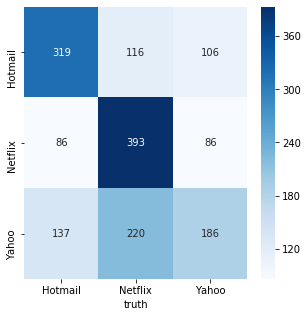

In [28]:
plt.figure(figsize=(5,5))
sns.heatmap(results,annot=True,fmt="d",
            xticklabels=aux_df['Password_Source'].values, 
            yticklabels=aux_df['Password_Source'].values,
            cmap="Blues")
plt.xlabel('Predicted')
plt.xlabel('truth')

### Classificatio report for random forest with max depth 20

In [29]:
print("Classification report for max depth 20")
print(classification_report(ytest, rf1.predict(xtest)))

Classification report for max depth 20
              precision    recall  f1-score   support

     Hotmail       0.60      0.58      0.59       541
     Netflix       0.65      0.76      0.70       565
       Yahoo       0.53      0.45      0.49       543

   micro avg       0.60      0.60      0.60      1649
   macro avg       0.59      0.60      0.59      1649
weighted avg       0.59      0.60      0.60      1649



In [30]:
results = confusion_matrix(ytest, rf1.predict(xtest))
print(results)

[[313  88 140]
 [ 56 431  78]
 [155 141 247]]


### confusion matrix with maxdepth 20

Text(0.5, 24.0, 'truth')

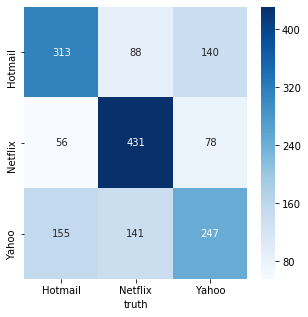

In [31]:
plt.figure(figsize=(5,5))
sns.heatmap(results,annot=True,fmt="d",
            xticklabels=aux_df['Password_Source'].values, 
            yticklabels=aux_df['Password_Source'].values,
            cmap="Blues")
plt.xlabel('Predicted')
plt.xlabel('truth')

### Classification report using randomised search

In [32]:
print("Classification report using randomised search")
print(classification_report(ytest, random_search.predict(xtest)))

Classification report using randomised search
              precision    recall  f1-score   support

     Hotmail       0.61      0.56      0.59       541
     Netflix       0.67      0.77      0.72       565
       Yahoo       0.54      0.50      0.52       543

   micro avg       0.61      0.61      0.61      1649
   macro avg       0.61      0.61      0.61      1649
weighted avg       0.61      0.61      0.61      1649



In [33]:
results = confusion_matrix(ytest, random_search.predict(xtest))
print(results)

[[304  87 150]
 [ 50 434  81]
 [144 126 273]]


### Confusion matrix using randomised search parameters

Text(0.5, 24.0, 'truth')

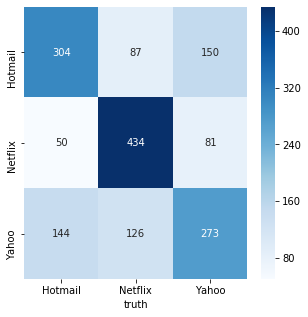

In [34]:
plt.figure(figsize=(5,5))
sns.heatmap(results,annot=True,fmt="d",
            xticklabels=aux_df['Password_Source'].values, 
            yticklabels=aux_df['Password_Source'].values,
            cmap="Blues")
plt.xlabel('Predicted')
plt.xlabel('truth')

### Classification report using grid search

In [35]:
print("Classification report using grid search")
print(classification_report(ytest, grid_search.predict(xtest)))

Classification report using grid search
              precision    recall  f1-score   support

     Hotmail       0.61      0.59      0.60       541
     Netflix       0.68      0.74      0.71       565
       Yahoo       0.51      0.48      0.49       543

   micro avg       0.60      0.60      0.60      1649
   macro avg       0.60      0.60      0.60      1649
weighted avg       0.60      0.60      0.60      1649



### Confusion matrix using grid search parameters

In [36]:
results = confusion_matrix(ytest, grid_search.predict(xtest))
print(results)

[[319  65 157]
 [ 53 416  96]
 [152 132 259]]


Text(0.5, 24.0, 'truth')

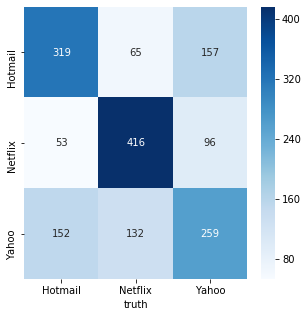

In [37]:
plt.figure(figsize=(5,5))
sns.heatmap(results,annot=True,fmt="d",
            xticklabels=aux_df['Password_Source'].values, 
            yticklabels=aux_df['Password_Source'].values,
            cmap="Blues")
plt.xlabel('Predicted')
plt.xlabel('truth')

### Classification using Support Vector Machine

In [38]:
from sklearn.svm import SVC
from sklearn import svm

In [39]:
clf=SVC()
clf.fit(xtrain,ytrain)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

### Accuracy

In [40]:
from sklearn.metrics import accuracy_score
print('Accuracy without hyper parameter tuning: ', 100 * accuracy_score(ytest, clf.predict(xtest)), '%')

Accuracy without hyper parameter tuning:  57.67131594906003 %


In [41]:
from sklearn.metrics import confusion_matrix, classification_report

In [42]:
results = confusion_matrix(ytest, clf.predict(xtest))
print(results)

[[ 71   6 464]
 [  2 375 188]
 [ 25  13 505]]


### Classification report 

In [43]:
print("Classification report without tuning")
print(classification_report(ytest, clf.predict(xtest)))

Classification report without tuning
              precision    recall  f1-score   support

     Hotmail       0.72      0.13      0.22       541
     Netflix       0.95      0.66      0.78       565
       Yahoo       0.44      0.93      0.59       543

   micro avg       0.58      0.58      0.58      1649
   macro avg       0.70      0.57      0.53      1649
weighted avg       0.71      0.58      0.54      1649



### Confusion matrix

Text(0.5, 24.0, 'truth')

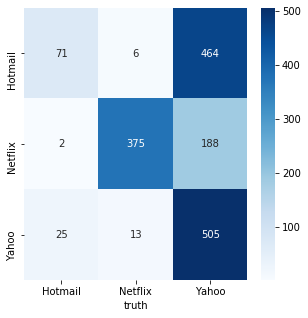

In [44]:
plt.figure(figsize=(5,5))
sns.heatmap(results,annot=True,fmt="d",
            xticklabels=aux_df['Password_Source'].values, 
            yticklabels=aux_df['Password_Source'].values,
            cmap="Blues")
plt.xlabel('Predicted')
plt.xlabel('truth')

### We can observe that performace od Random Forest Classifier is pretty much good compared to SVM